In [ ]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from tensorflow.keras.applications import Xception

from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications import VGG16, VGG19

from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator\

from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
import os
import shutil
import numpy as np


# Define paths
source_dir = '/content/drive/MyDrive/covid projrct dataset 2'
train_dir = '/content/drive/MyDrive/train test val 2/train'
val_dir = '/content/drive/MyDrive/train test val 2/val'
test_dir = '/content/drive/MyDrive/train test val 2/test'

In [ ]:





# Calculate class weights
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        print(class_name)
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_in_classes(train_dir)
num_classes = len(train_class_counts)
total_samples = sum(train_class_counts.values())

class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(train_class_counts.values())}
print("Class weights:", class_weights)

COVID
NORMAL
pneumonia
Class weights: {0: 1.369757174392936, 1: 0.8820184790334044, 2: 0.8801418439716312}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test data without data augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2482 images belonging to 3 classes.
Found 531 images belonging to 3 classes.
Found 535 images belonging to 3 classes.


In [ ]:

num_batches = len(train_generator)
total_new_data = num_batches * train_generator.batch_size

print("Total new data generated:", total_new_data)
print(num_batches)

Total new data generated: 2496
78


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),  # Add dropout for regularization
    Dense(128, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# Define callbacks
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=1e-6)

callbacks = [checkpoint, lr_scheduler]

# Training configuration
epochs = 20
# Start training
start_time = datetime.now()

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks,class_weight=class_weights)

# Calculate training duration
training_duration = datetime.now() - start_time
print("Training duration:", training_duration)


Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 5.5776 - accuracy: 0.7313
Epoch 1: val_loss improved from inf to 6.75770, saving model to model_checkpoint.h5
78/78 [==============================] - 636s 8s/step - loss: 5.5776 - accuracy: 0.7313 - val_loss: 6.7577 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - ETA: 0s - loss: 2.9739 - accuracy: 0.8429
Epoch 2: val_loss improved from 6.75770 to 2.95908, saving model to model_checkpoint.h5
78/78 [==============================] - 432s 6s/step - loss: 2.9739 - accuracy: 0.8429 - val_loss: 2.9591 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 1.9311 - accuracy: 0.8723
Epoch 3: val_loss improved from 2.95908 to 1.83596, saving model to model_checkpoint.h5
78/78 [==============================] - 432s 6s/step - loss: 1.9311 - accuracy: 0.8723 - val_loss: 1.8360 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 1.3751 - accuracy: 0.8848
Epoch 4: val_loss improved from 1.83596 to 1.14558, saving model to model_checkpoint.h5
78/78 [==============================] - 431s 6s/step - loss: 1.3751 - accuracy: 0.8848 - val_loss: 1.1456 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 5/20
78/78 [==================

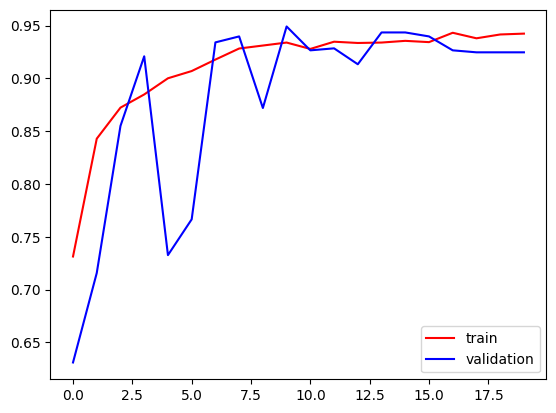

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

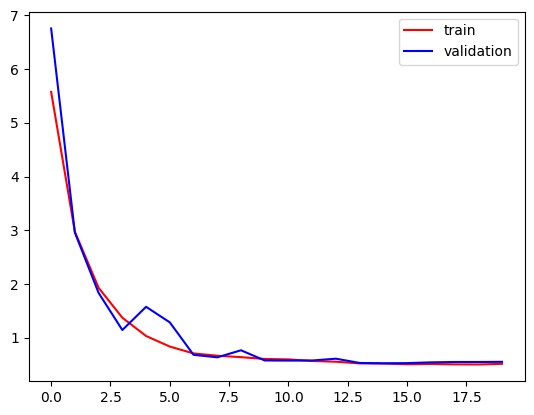

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

17/17 [==============================] - 106s 6s/step - loss: 0.5824 - accuracy: 0.9159
Test Loss: 0.5823804140090942
Test Accuracy: 0.9158878326416016


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)

# Predict classes for training set
train_predictions = model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Predict classes for validation set
test_predictions = model.predict(test_generator)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get true labels for validation set
test_true_classes = test_generator.classes

# Generate classification report for validation set
test_report = classification_report(test_true_classes, test_predicted_classes, target_names=class_labels)

print("test Classification Report:")
print(test_report)


78/78 [==============================] - 296s 4s/step
Training Classification Report:
              precision    recall  f1-score   support

       COVID       0.26      0.27      0.27       604
      NORMAL       0.39      0.39      0.39       938
   pneumonia       0.38      0.37      0.37       940

    accuracy                           0.35      2482
   macro avg       0.34      0.34      0.34      2482
weighted avg       0.35      0.35      0.35      2482

17/17 [==============================] - 64s 4s/step
test Classification Report:
              precision    recall  f1-score   support

       COVID       0.26      0.27      0.27       131
      NORMAL       0.40      0.44      0.42       202
   pneumonia       0.38      0.33      0.35       202

    accuracy                           0.36       535
   macro avg       0.35      0.35      0.35       535
weighted avg       0.36      0.36      0.36       535

